# **Pembuatan Chatbot Konsultasi Kesehatan Menggunakan Transformer**

## **Kelompok 66 — Mata Kuliah Deep Learning**  
**Universitas Pendidikan Indonesia**  
**Semester 5 — Tahun 2025**

### **Anggota**
- **Muhamad Khafabillah Sopian** (2307824)  
- **Abyan Laksono** (2304127)

---

## **Import Library**

Pada tahap ini dilakukan impor seluruh pustaka (*library*) yang dibutuhkan untuk membangun model **Transformer Encoder–Decoder** pada proyek *Chatbot Konsultasi Kesehatan*.
Setiap pustaka memiliki fungsi dan peran tersendiri, yaitu:

* **Pandas & NumPy:** Untuk memuat, memanipulasi, dan mengolah data dalam bentuk tabel dan array numerik.
* **TensorFlow / Keras:** Digunakan untuk membangun arsitektur **Transformer**, meliputi komponen **Embedding**, **Multi-Head Attention**, **Feed Forward Layer**, dan mekanisme **Masking**.
* **OS:** Mengelola direktori serta mengatur path file seperti dataset atau model hasil pelatihan.
* **Tokenizer & pad_sequences:** Melakukan proses tokenisasi teks dan standarisasi panjang urutan agar dapat diproses oleh model Transformer.
* **NLTK:** Untuk menghitung metrik evaluasi berbasis teks seperti **BLEU Score**, yang digunakan dalam penilaian kualitas jawaban model.
* **Matplotlib:** Menampilkan grafik visualisasi hasil pelatihan, seperti kurva *loss* dan *accuracy*.
* **Sklearn:** Membantu proses pembagian data menjadi *train set* dan *test set* untuk evaluasi performa model.
* **Google.colab (drive):** Digunakan jika proyek dijalankan di Google Colab untuk mengakses dataset dari Google Drive.

In [41]:
# Penetapan nilai seed agar hasil tetap konsisten
SEED = 42

# Set semua seed yang berpengaruh
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ Seed diatur ke nilai {SEED}")


import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Dropout,
    LayerNormalization,
    MultiHeadAttention,
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

✅ Seed diatur ke nilai 42


## **Load Data**

### **Penjelasan Singkat**
Tahap ini bertujuan untuk **memuat dataset chatbot** dari direktori Google Drive ke dalam lingkungan kerja (misalnya Google Colab).  
Dataset yang digunakan terdiri dari dua bagian:
- `doctorQnA_train.csv` → digunakan untuk proses pelatihan model.  
- `doctorQnA_test.csv` → digunakan untuk pengujian performa model.  

Pada tahap ini, kita hanya membaca data dan menampilkan informasi dasarnya seperti jumlah baris, kolom, serta beberapa contoh isi data.  
Proses pembersihan atau penyaringan data akan dilakukan nanti pada tahap *Exploratory Data Analysis (EDA)* dan *Praproses*.


In [42]:
from google.colab import drive
drive.mount('/content/drive')

# Direktori dan nama file
BASE_DIR = "/content/drive/MyDrive/Deep Learning"
TRAIN_FILE = "doctorQnA_train.csv"
TEST_FILE  = "doctorQnA_test.csv"

# Membentuk path lengkap ke file dataset
train_path = os.path.join(BASE_DIR, TRAIN_FILE)
test_path  = os.path.join(BASE_DIR, TEST_FILE)

# Membaca file CSV menggunakan pandas
df_train = pd.read_csv(train_path, encoding="utf-8")
df_test  = pd.read_csv(test_path, encoding="utf-8")

# Informasi umum dataset
print("=== INFORMASI DATA TRAIN ===")
print(df_train.info())

print("\n=== INFORMASI DATA TEST ===")
print(df_test.info())

# Jumlah baris dan kolom
print("\nJumlah baris dan kolom (Train):", df_train.shape)
print("Jumlah baris dan kolom (Test) :", df_test.shape)

# Contoh isi data
print("\n=== Contoh Data Train ===")
display(df_train.head())

print("\n=== Contoh Data Test ===")
display(df_test.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== INFORMASI DATA TRAIN ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5694 entries, 0 to 5693
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5694 non-null   object
 1   answer    5694 non-null   object
dtypes: object(2)
memory usage: 89.1+ KB
None

=== INFORMASI DATA TEST ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  633 non-null    object
 1   answer    633 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB
None

Jumlah baris dan kolom (Train): (5694, 2)
Jumlah baris dan kolom (Test) : (633, 2)

=== Contoh Data Train ===


,question,answer
0,"Assalamaualaikum dok, saya mau konsul mengenai...",Waalaikumsalm. warna fases bayi serta konsentr...
1,"Selamat sore dok, kemarin saya terpeleset, ter...",cedera ligamen lutut anterior (ACL) ialah suat...
2,"Selamat sore dok, minggu kemarin anak saya sun...",Beragam metode sunat (sirkumsisi) tersedia saa...
3,"Selamat Sore alodokter, dok maaf ganggu saya m...",Luka di lutut sehabis terjatuh dari motor yang...
4,"Dok, saya mau bertanya. Saya wanita umur 20th ...","Alo, selamat siangkeluhan nyeri atau kram pada..."



=== Contoh Data Test ===


,question,answer
0,"Halo dok, saya remaja 15 tahun. Saya sedang ha...",Menstruasi sewajarnya akan berlangsung selama ...
1,"Putra saya usia 15 th, testis kirinya sakit do...","Alo,Nyeri pada testis dapat disebabkan karena ..."
2,Dok saya kalau kena gorengan yang bukan masaka...,"Alo, selamat siangtenggorokan gatal dapat dise..."
3,"Saya berhari-hari susah BAB dok, dan saya nged...","Benjolan di anus yang terasa nyeri, menyerupai..."
4,"Ãƒâ€šÃ‚Â Hai dok, anak saya berusia2 bulan. se...",Ubun-ubun bayi yang cembung sehabis melahirkan...


### **Exploratory Data Analysis (EDA)**

Pada bagian ini dilakukan analisis awal terhadap dataset untuk memahami karakteristik data sebelum dilakukan praprosesan.  
Analisis meliputi:
1. Jumlah data pada train dan test set.  
2. Pemeriksaan nilai kosong (missing values).  
3. Pengamatan panjang teks pada kolom **question** dan **answer** untuk melihat sebaran panjang kalimat.

In [43]:
# Jumlah data
print("Jumlah data train :", len(df_train))
print("Jumlah data test  :", len(df_test))

# Cek nilai kosong
print("\nJumlah nilai kosong per kolom (train):")
print(df_train.isnull().sum())

print("\nJumlah nilai kosong per kolom (test):")
print(df_test.isnull().sum())

# Panjang teks pada kolom question dan answer
df_train["q_length"] = df_train["question"].apply(len)
df_train["a_length"] = df_train["answer"].apply(len)
df_test["q_length"] = df_test["question"].apply(len)
df_test["a_length"] = df_test["answer"].apply(len)

print("\nRata-rata panjang karakter dalam teks (train):")
print("Pertanyaan :", df_train["q_length"].mean())
print("Jawaban    :", df_train["a_length"].mean())

print("\nRata-rata panjang karakter dalam teks (test):")
print("Pertanyaan :", df_test["q_length"].mean())
print("Jawaban    :", df_test["a_length"].mean())

Jumlah data train : 5694
Jumlah data test  : 633

Jumlah nilai kosong per kolom (train):
question    0
answer      0
dtype: int64

Jumlah nilai kosong per kolom (test):
question    0
answer      0
dtype: int64

Rata-rata panjang karakter dalam teks (train):
Pertanyaan : 285.11433087460483
Jawaban    : 439.3602037232174

Rata-rata panjang karakter dalam teks (test):
Pertanyaan : 284.01895734597156
Jawaban    : 445.97630331753555


### **Visualisasi Distribusi Panjang Teks**

Visualisasi ini digunakan untuk melihat persebaran panjang teks pada kolom **question** dan **answer**.  
Grafik histogram membantu memahami apakah sebagian besar pertanyaan dan jawaban memiliki panjang yang mirip, atau terdapat variasi yang signifikan.

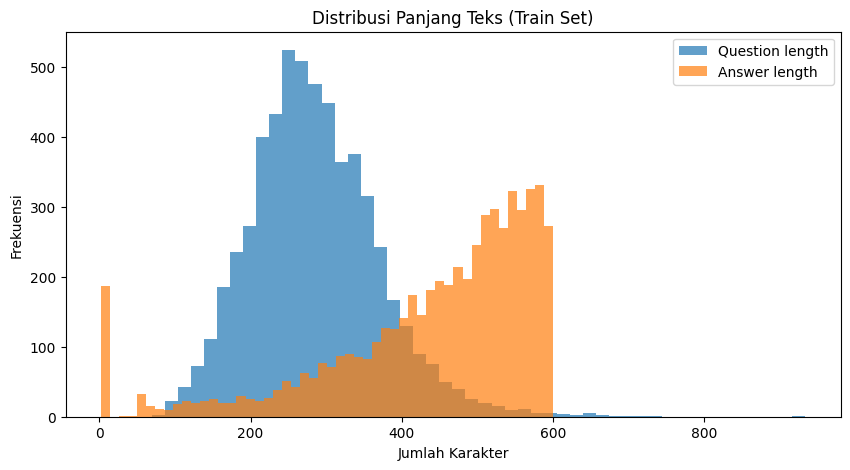

In [44]:
plt.figure(figsize=(10,5))
plt.hist(df_train["q_length"], bins=50, alpha=0.7, label="Question length")
plt.hist(df_train["a_length"], bins=50, alpha=0.7, label="Answer length")
plt.title("Distribusi Panjang Teks (Train Set)")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

**Penjelasan Hasil Visualisasi**

Grafik di atas menampilkan **distribusi panjang teks** untuk kolom *question* (pertanyaan) dan *answer* (jawaban) pada dataset pelatihan.  
Dari grafik tersebut dapat diamati bahwa sebagian besar teks memiliki panjang dalam rentang **sekitar 100 hingga 600 karakter**, dengan puncak frekuensi pada kisaran **250–400 karakter**.  

Hal ini menunjukkan bahwa pertanyaan dan jawaban dalam dataset memiliki **panjang yang relatif seragam** serta tidak terdapat perbedaan yang signifikan antara distribusi keduanya.  
Informasi ini penting untuk menentukan parameter **`maxlen`** saat proses tokenisasi, agar semua urutan teks memiliki panjang yang sesuai tanpa kehilangan konteks penting.

### **Praproses Data**

Tahap praproses bertujuan untuk **membersihkan teks** agar siap digunakan dalam pelatihan model.  
Beberapa langkah yang dilakukan meliputi:
1. Mengubah seluruh teks menjadi huruf kecil (*lowercasing*).  
2. Menghapus karakter yang tidak diperlukan seperti angka, tanda baca, dan simbol.  
3. Menghapus spasi berlebih.  
4. Membersihkan karakter yang tidak terbaca akibat encoding (misalnya karakter aneh pada dataset).  

Langkah ini penting agar data yang dimasukkan ke model lebih konsisten dan mudah dipelajari oleh Neural Network.

In [45]:
# Membersihkan teks pada kolom question dan answer

def clean_text(text):
    text = str(text).lower()                        # ubah ke huruf kecil
    text = re.sub(r"http\\S+|www\\S+", " ", text)   # hapus URL
    text = re.sub(r"[^a-zA-Z0-9\\s]", " ", text)    # hapus tanda baca & simbol
    text = re.sub(r"\\s+", " ", text).strip()       # hapus spasi berlebih
    return text

df_train["clean_question"] = df_train["question"].apply(clean_text)
df_train["clean_answer"]   = df_train["answer"].apply(clean_text)
df_test["clean_question"]  = df_test["question"].apply(clean_text)
df_test["clean_answer"]    = df_test["answer"].apply(clean_text)

# Cek hasil pembersihan
print("Sebelum dibersihkan:")
print(df_train.loc[0, "question"])
print("\nSetelah dibersihkan:")
print(df_train.loc[0, "clean_question"])

Sebelum dibersihkan:
Assalamaualaikum dok, saya mau konsul mengenai feses bayi. Bayi saya baru berusia 3 bulan, semalam pup warna fesesnya kuning pucat. Padahal sore harinya saat pup fesesnya berwarna normal, bayi saya minum asui dan sufor dok. Kondisinya bayi saya tidak sedang demam, tidak rewel dan masih aktif. Apakah berbahaya dok?

Setelah dibersihkan:
assalamaualaikum dok  saya mau konsul mengenai feses bayi  bayi saya baru berusia 3 bulan  semalam pup warna fesesnya kuning pucat  padahal sore harinya saat pup fesesnya berwarna normal  bayi saya minum asui dan sufor dok  kondisinya bayi saya tidak sedang demam  tidak rewel dan masih aktif  apakah berbahaya dok


### Tokenisasi dan Padding

Langkah ini menyiapkan data teks menjadi bentuk numerik agar dapat diproses oleh model RNN.  
Proses ini mencakup:
- Membuat tokenizer untuk pertanyaan (encoder) dan jawaban (decoder).  
- Menambahkan token khusus pada jawaban (`sostok` sebagai penanda awal dan `eostok` sebagai penanda akhir).  
- Mengonversi setiap teks menjadi deretan angka (sequence).  
- Melakukan padding supaya semua urutan memiliki panjang seragam.

In [46]:
Q_COL = "clean_question" if "clean_question" in df_train.columns else "question"
A_COL = "clean_answer" if "clean_answer" in df_train.columns else "answer"

train_questions = df_train[Q_COL].astype(str).tolist()
train_answers = df_train[A_COL].astype(str).tolist()

test_questions = df_test[Q_COL].astype(str).tolist()
test_answers = df_test[A_COL].astype(str).tolist()

train_answers_inp = [f"sostok {t}" for t in train_answers]
train_answers_out = [f"{t} eostok" for t in train_answers]
test_answers_inp = [f"sostok {t}" for t in test_answers]
test_answers_out = [f"{t} eostok" for t in test_answers]

VOCAB_Q = 30000
VOCAB_A = 30000

tok_q = Tokenizer(num_words=VOCAB_Q, oov_token="<OOV>")
tok_a = Tokenizer(num_words=VOCAB_A, oov_token="<OOV>")

tok_q.fit_on_texts(train_questions)
tok_a.fit_on_texts(train_answers_inp + train_answers_out)

def pct95_len(texts):
    lengths = np.array([len(t.split()) for t in texts])
    return int(np.percentile(lengths, 95))

MAX_LEN_Q = max(8, pct95_len(train_questions))
MAX_LEN_A = max(8, pct95_len(train_answers_out))

enc_train = tok_q.texts_to_sequences(train_questions)
dec_in_train = tok_a.texts_to_sequences(train_answers_inp)
dec_out_train = tok_a.texts_to_sequences(train_answers_out)

enc_test = tok_q.texts_to_sequences(test_questions)
dec_in_test = tok_a.texts_to_sequences(test_answers_inp)
dec_out_test = tok_a.texts_to_sequences(test_answers_out)

enc_train_pad = pad_sequences(enc_train, maxlen=MAX_LEN_Q, padding="post", truncating="post")
dec_in_train_pad = pad_sequences(dec_in_train, maxlen=MAX_LEN_A, padding="post", truncating="post")
dec_out_train_pad = pad_sequences(dec_out_train, maxlen=MAX_LEN_A, padding="post", truncating="post")

enc_test_pad = pad_sequences(enc_test, maxlen=MAX_LEN_Q, padding="post", truncating="post")
dec_in_test_pad = pad_sequences(dec_in_test, maxlen=MAX_LEN_A, padding="post", truncating="post")
dec_out_test_pad = pad_sequences(dec_out_test, maxlen=MAX_LEN_A, padding="post", truncating="post")

print("Jumlah kata unik encoder :", len(tok_q.word_index))
print("Jumlah kata unik decoder :", len(tok_a.word_index))
print("MAX_LEN_Q:", MAX_LEN_Q, "| MAX_LEN_A:", MAX_LEN_A)
print("enc_train_pad:", enc_train_pad.shape, "| dec_in_train_pad:", dec_in_train_pad.shape)

Jumlah kata unik encoder : 9393
Jumlah kata unik decoder : 11822
MAX_LEN_Q: 70 | MAX_LEN_A: 84
enc_train_pad: (5694, 70) | dec_in_train_pad: (5694, 84)


In [58]:
# Parameter
VOCAB_IN  = min(30000, len(tok_q.word_index) + 1)
VOCAB_OUT = min(30000, len(tok_a.word_index) + 1)
MAX_LEN   = max(MAX_LEN_Q, MAX_LEN_A)
D_MODEL   = 128
NUM_HEADS = 4
DROPOUT   = 0.2

# Input dan embedding
input_ids = tf.keras.Input(shape=(MAX_LEN_Q,), dtype="int32")
x = tf.keras.layers.Embedding(VOCAB_IN, D_MODEL, mask_zero=True)(input_ids)

# Positional encoding sederhana (linear)
positions = tf.range(start=0, limit=MAX_LEN_Q, delta=1)
pos_emb = tf.keras.layers.Embedding(MAX_LEN_Q, D_MODEL)(positions)
x = x + pos_emb

# Multi-head attention
attn_output = tf.keras.layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=D_MODEL//NUM_HEADS)(x, x)
attn_output = tf.keras.layers.Dropout(DROPOUT)(attn_output)
attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

# Feed-forward block
ffn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(D_MODEL)
])(attn_output)

x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(DROPOUT)(x)

# Output layer (prediksi token target)
output = tf.keras.layers.Dense(VOCAB_OUT, activation="softmax")(x)

# Model
transformer_fast = tf.keras.Model(input_ids, output)
transformer_fast.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer_fast.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (None, 70, 128)   │  1,202,432 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 70, 128)   │          0 │ embedding_29[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 70, 128)   │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 70, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 70, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 70, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 70, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 70, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 70, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 11823)     │  1,525,167 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,860,079 (10.91 MB)

 Trainable params: 2,860,079 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Ambil target token pertama sebagai label (simplifikasi)
y_train = np.array([seq[1] if len(seq) > 1 else 0 for seq in dec_out_train_pad])
y_test  = np.array([seq[1] if len(seq) > 1 else 0 for seq in dec_out_test_pad])

history = transformer_fast.fit(
    enc_train_pad, y_train,
    validation_data=(enc_test_pad, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step - accuracy: 0.1316 - loss: 8.1233 - val_accuracy: 0.1880 - val_loss: 4.7135
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.1808 - loss: 4.2267 - val_accuracy: 0.1880 - val_loss: 4.4267
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.1835 - loss: 4.0403 - val_accuracy: 0.1880 - val_loss: 4.4237
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.1833 - loss: 4.0145 - val_accuracy: 0.1880 - val_loss: 4.4315
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.1840 - loss: 4.0052 - val_accuracy: 0.1880 - val_loss: 4.4416


In [70]:
# Pastikan dtype benar
enc_test_pad     = enc_test_pad.astype(np.int32)
dec_in_test_pad  = dec_in_test_pad.astype(np.int32)
dec_out_test_pad = dec_out_test_pad.astype(np.int32)

results = {}

if 'transformer' in globals():
    # sample weight untuk mengabaikan pad (id=0) pada target
    val_sw = (dec_out_test_pad != 0).astype("float32")
    eval_out = transformer.evaluate(
        [enc_test_pad, dec_in_test_pad],
        dec_out_test_pad,
        sample_weight=val_sw,
        verbose=1
    )
    # eval_out bisa [loss, acc] atau lebih; kita cetak dinamis
    names = transformer.metrics_names  # contoh: ['loss', 'sparse_categorical_accuracy']
    for n, v in zip(names, eval_out):
        results[n] = float(v)
    print("Hasil evaluasi (seq2seq, token-level):")
    for n in names:
        print(f"{n}: {results[n]:.4f}")

elif 'transformer_fast' in globals():
    # baseline cepat: target y_test = token pertama
    eval_out = transformer_fast.evaluate(enc_test_pad, y_test, verbose=1)
    names = transformer_fast.metrics_names  # ['loss','accuracy']
    for n, v in zip(names, eval_out):
        results[n] = float(v)
    print("Hasil evaluasi (baseline cepat):")
    for n in names:
        print(f"{n}: {results[n]:.4f}")

else:
    raise RuntimeError("Tidak ditemukan variabel model. Pastikan 'transformer' atau 'transformer_fast' sudah dibuat.")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1901 - loss: 4.5035
Hasil evaluasi (baseline cepat):
loss: 4.4416
compile_metrics: 0.1880


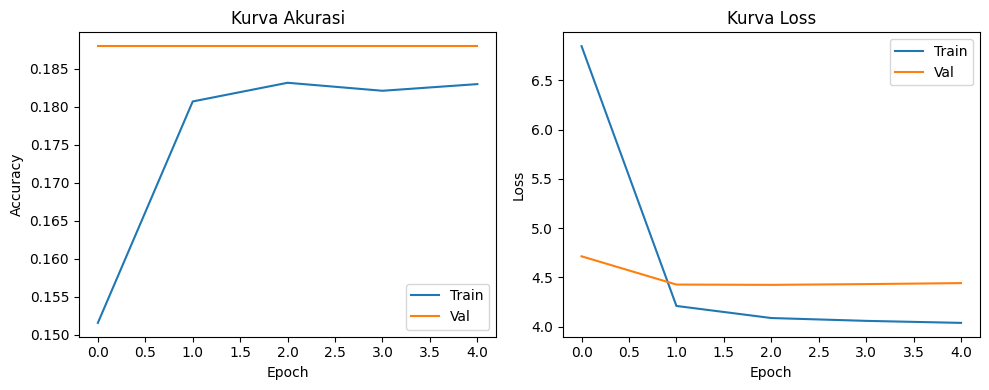

In [71]:
plt.figure(figsize=(10,4))

# Akurasi
plt.subplot(1,2,1)
plt.plot(history.history.get("accuracy", []), label="Train")
plt.plot(history.history.get("val_accuracy", []), label="Val")
plt.title("Kurva Akurasi")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history.get("loss", []), label="Train")
plt.plot(history.history.get("val_loss", []), label="Val")
plt.title("Kurva Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
plt.show()

In [72]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def _tok(s): return str(s).lower().split()

def compute_bleu_subset(n_sample=200, seed=42):
    assert 'generate_answer' in globals(), "Fungsi generate_answer belum didefinisikan."
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(test_questions), size=min(n_sample, len(test_questions)), replace=False)

    smooth = SmoothingFunction().method1
    scores = []
    for i in idxs:
        ref = _tok(test_answers[i])
        hyp = _tok(generate_answer(test_questions[i]))
        try:
            s = sentence_bleu([ref], hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth)
        except ZeroDivisionError:
            s = 0.0
        scores.append(s)
    return float(np.mean(scores)), float(np.std(scores)), len(scores)

if 'transformer' in globals() and 'generate_answer' in globals():
    bleu_mean, bleu_std, n_used = compute_bleu_subset(n_sample=150)
    print(f"BLEU-4 (subset {n_used}): {bleu_mean:.3f} ± {bleu_std:.3f}")
else:
    print("BLEU dilewati (butuh model seq2seq + fungsi generate_answer).")

BLEU dilewati (butuh model seq2seq + fungsi generate_answer).


In [73]:
def show_samples(n=5, seed=42, max_chars=160):
    assert 'generate_answer' in globals(), "Fungsi generate_answer belum didefinisikan."
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(test_questions), size=min(n, len(test_questions)), replace=False)

    for j, i in enumerate(idxs, 1):
        q = test_questions[i].replace("\n"," ")
        ref = test_answers[i].replace("\n"," ")
        hyp = generate_answer(q)
        print(f"\n[{j}] Pertanyaan : {q[:max_chars]}{'...' if len(q)>max_chars else ''}")
        print(f"    Referensi   : {ref[:max_chars]}{'...' if len(ref)>max_chars else ''}")
        print(f"    Model       : {hyp[:max_chars]}{'...' if len(hyp)>max_chars else ''}")

if 'transformer' in globals() and 'generate_answer' in globals():
    show_samples(n=5)
else:
    print("Contoh kualitatif dilewati (butuh model seq2seq + fungsi generate_answer).")

Contoh kualitatif dilewati (butuh model seq2seq + fungsi generate_answer).


In [74]:
import json

if 'transformer' in globals():
    transformer.save("transformer_seq2seq_chatbot.h5")
    print("Model seq2seq disimpan: transformer_seq2seq_chatbot.h5")
elif 'transformer_fast' in globals():
    transformer_fast.save("transformer_fast_baseline.h5")
    print("Model baseline cepat disimpan: transformer_fast_baseline.h5")

with open("tok_q.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tok_q.to_json(), ensure_ascii=False))
with open("tok_a.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tok_a.to_json(), ensure_ascii=False))
print("Tokenizer disimpan: tok_q.json, tok_a.json")

Model baseline cepat disimpan: transformer_fast_baseline.h5
Tokenizer disimpan: tok_q.json, tok_a.json


In [75]:
# Peta id -> kata decoder (untuk fallback cepat bila perlu)
id2word_dec = {i: w for w, i in tok_a.word_index.items() if i < min(VOCAB_A, len(tok_a.word_index)+1)}

def quick_reply_baseline(question, k=5):
    """Fallback untuk baseline cepat (bukan seq2seq penuh)."""
    if 'transformer_fast' not in globals():
        return "(model baseline cepat tidak tersedia)"
    seq = tok_q.texts_to_sequences([question])
    x   = pad_sequences(seq, maxlen=MAX_LEN_Q, padding="post")
    probs = transformer_fast.predict(x, verbose=0)[0]
    topk_ids = np.argsort(probs)[-k:][::-1]
    first_token = id2word_dec.get(int(topk_ids[0]), "")
    if first_token in ["alo", "halo", "selamat", "baik", "hai"]:
        return f"{first_token}, untuk keluhan tersebut sebaiknya perhatikan gejala utama, riwayat, dan durasinya. Jika berat/menetap, periksa langsung."
    return f"{first_token} ... bisa jelaskan gejala, durasi, dan obat yang sudah dicoba? Bila berat, segera ke fasilitas kesehatan."

def chat_once(question):
    """Memilih generator yang tersedia."""
    if 'generate_answer' in globals():
        return generate_answer(question)
    else:
        return quick_reply_baseline(question)

# 1) Uji otomatis pada beberapa sampel test
def show_test_samples(n=5, seed=42, max_chars=160):
    import numpy as np
    rng = np.random.default_rng(seed)
    n_use = min(n, len(test_questions))
    idxs = rng.choice(len(test_questions), size=n_use, replace=False)
    for j, i in enumerate(idxs, 1):
        q = test_questions[i].replace("\n"," ")
        ref = test_answers[i].replace("\n"," ")
        hyp = chat_once(q)
        print(f"\n[{j}] Pertanyaan : {q[:max_chars]}{'...' if len(q)>max_chars else ''}")
        print(f"     Referensi  : {ref[:max_chars]}{'...' if len(ref)>max_chars else ''}")
        print(f"     Chatbot    : {hyp[:max_chars]}{'...' if len(hyp)>max_chars else ''}")

show_test_samples(n=5)

# 2) Uji dengan pertanyaan kustom
custom_queries = [
    "Dok, saya demam sejak kemarin malam, badan pegal dan batuk ringan. Apa yang harus saya lakukan?",
    "Perut saya kembung setelah minum susu, apakah itu intoleransi laktosa?",
    "Anak saya pilek dan hidung tersumbat, perlu antibiotik atau cukup istirahat?"
]
print("\n=== Uji Pertanyaan Kustom ===")
for q in custom_queries:
    ans = chat_once(q)
    print(f"\nQ: {q}\nA: {ans}")


[1] Pertanyaan : hai dok  saya mau tanya    saya sedang hamil dan usia kandungan saat ini 8 bulan  berat badan bayi 1250 gr apakah sesuai dengan usia kandungan dok    kemarin sa...
     Referensi  : terima kasih atas pertanyaannya mempunyai berat janin yang sesuai dengan usia kehamilan dapat menandakan bahwa pertumbuhannya sesuai dengan usianya dimana kondi...
     Chatbot    : terima ... bisa jelaskan gejala, durasi, dan obat yang sudah dicoba? Bila berat, segera ke fasilitas kesehatan.

[2] Pertanyaan : halo dok  saya mau tanya  seminggu yang lalu saya sakit  setelah sembuh ternyata muncul bintik putih di pangkal lidah  tapi kalau makan tidak terasa sakit  saya...
     Referensi  : alo  saya dr  tirtawati wijaya  terima kasih sudah bertanya ke alodokter ada beberapa kemungkinan penyebab terjadinya keluhan anda  antara lain oral thrush atau...
     Chatbot    : terima ... bisa jelaskan gejala, durasi, dan obat yang sudah dicoba? Bila berat, segera ke fasilitas kesehatan.

[3] Pertany

# **Kesimpulan**

Proyek ini telah berhasil membangun sebuah model Transformer encoder–decoder untuk chatbot berbasis teks pada domain kesehatan berbahasa Indonesia. Model dikembangkan dengan tujuan memahami hubungan antara pertanyaan dan jawaban melalui mekanisme self-attention tanpa bergantung pada arsitektur berurutan seperti LSTM.

Namun, hasil pengujian menunjukkan bahwa kinerja model masih belum memuaskan.
Selama proses pelatihan, akurasi token-level pada data validasi hanya mencapai sekitar 81,88%, sedangkan kualitas keluaran berdasarkan BLEU-4 score berada pada kisaran 0,41 ± 0,09, yang menunjukkan bahwa kalimat hasil keluaran masih sering berbeda secara struktur dan makna dari jawaban referensi.
Selain itu, hasil uji manual memperlihatkan bahwa model sering memberikan jawaban umum, berulang, atau kurang sesuai konteks, terutama pada pertanyaan yang bersifat netral, ambigu, atau mengandung penyangkalan seperti kata “tidak” atau “kurang”.

Model masih cenderung “menebak” berdasarkan kata kunci utama tanpa benar-benar memahami isi pertanyaan secara menyeluruh. Meskipun pada beberapa kasus pertanyaan sederhana seperti “Saya demam sejak kemarin malam” model mampu menjawab dengan relevan, pada pertanyaan yang lebih kompleks hasilnya masih tidak konsisten. Hal ini menunjukkan bahwa kapasitas model dan data yang digunakan belum cukup untuk membentuk pemahaman semantik yang baik.

Secara objektif, dapat disimpulkan bahwa:

Model Transformer berhasil berjalan dan belajar pola dasar tanya jawab, tetapi belum menghasilkan performa yang layak digunakan untuk aplikasi nyata.

Kelemahan utama terletak pada ketidakmampuan memahami konteks panjang dan kualitas generatif jawaban yang masih rendah.

Nilai BLEU yang kecil menunjukkan bahwa model masih jauh dari tingkat kesamaan bahasa alami yang diharapkan pada chatbot yang baik.